# Objective:

Develop a predictive model to estimate the concentration of NO2 (Nitrogen Dioxide) levels based on meteorological and other air pollutant measurements.

## 🔍 Steps to Follow:
### 1. Data Acquisition & Preprocessing:
* Load the dataset from UCI and handle missing values.
* Convert timestamp data into appropriate formats (e.g., extracting hours, weekdays, seasons).
* Scale and normalize numerical features.

### 2. Exploratory Data Analysis (EDA):
* Visualize pollutant concentration trends over time.
* Analyze correlations between meteorological conditions (temperature, humidity, etc.) and pollution levels.
* Identify outliers and seasonal variations.

### 3. Feature Engineering:
* Create new features such as rolling averages or lag features for NO2 prediction.
* Encode categorical variables, if any.

### 4. Model Development:
* Train regression models to predict NO2 concentration using features such as CO, NOx, temperature, and humidity.
* Compare different models:
  * Linear Regression
  * Random Forest Regressor
  * LSTM (for time-series forecasting)
* Evaluate models using RMSE and R² scores.

## Insights & Recommendations:
* Determine the most important factors influencing air pollution.
* Suggest potential interventions based on the findings.

## Import necessary libraries

In [288]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK
import optuna


c:\Users\uif93590\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Acquisition & Preprocessing

In [264]:
base_dir = os.path.dirname(os.getcwd())
xlsx_path = os.path.join(base_dir, 'data', 'raw', 'AirQualityUCI.xlsx')

df = pd.read_excel(xlsx_path)

In [265]:
df.head

<bound method NDFrame.head of            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0    2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1    2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2    2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3    2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4    2004-03-10  22:00:00     1.6      1272.25        51   6.518224   
...         ...       ...     ...          ...       ...        ...   
9352 2005-04-04  10:00:00     3.1      1314.25      -200  13.529605   
9353 2005-04-04  11:00:00     2.4      1162.50      -200  11.355157   
9354 2005-04-04  12:00:00     2.4      1142.00      -200  12.374538   
9355 2005-04-04  13:00:00     2.1      1002.50      -200   9.547187   
9356 2005-04-04  14:00:00     2.2      1070.75      -200  11.932060   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0           1045.50    166.0       1056.25    11

In [266]:
print("\nMissing Values:\n")
print(df.isnull().sum())


Missing Values:

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


Add datetime, weekdays, months and hour to the columns.

In [267]:
datetime_column = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time'], inplace=True)
df.insert(0, column='Datetime', value=datetime_column)
df.insert(1, column='Weekday', value=df['Datetime'].dt.dayofweek)
df.insert(2, column='Month', value=df['Datetime'].dt.month)
df.insert(3, column='Hour', value=df['Datetime'].dt.hour)

Missing values are tagged with -200 value. Dropping records would result in an inconsistent dataset.

In [268]:
missing_counts = (df == -200).sum()
print(missing_counts)

Datetime            0
Weekday             0
Month               0
Hour                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


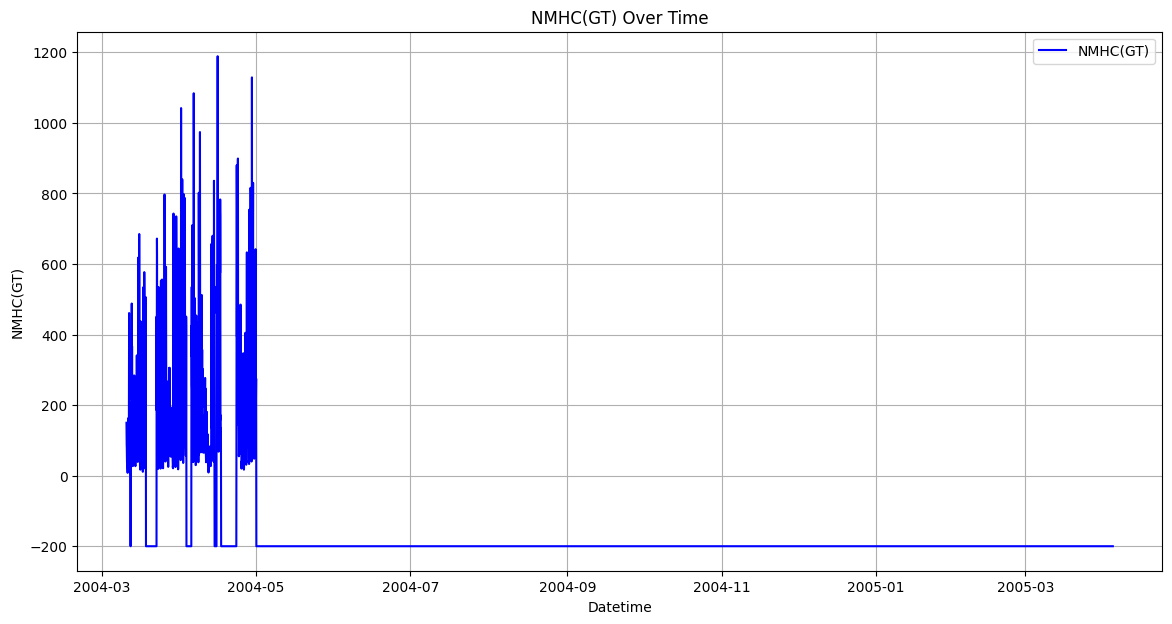

In [269]:
plt.figure(figsize=(14, 7))
plt.plot(df['Datetime'], df['NMHC(GT)'], label='NMHC(GT)', color='blue')
plt.xlabel('Datetime')
plt.ylabel('NMHC(GT)')
plt.title('NMHC(GT) Over Time')
plt.legend()
plt.grid(True)
plt.show()

This amount of spare datas can only be solved with models which can handle NaNs. Replace -200 values with NaN.

In [270]:
df.replace(to_replace=-200, value=np.nan, inplace=True)

## EDA

### Data Distribution


Data Distribution:


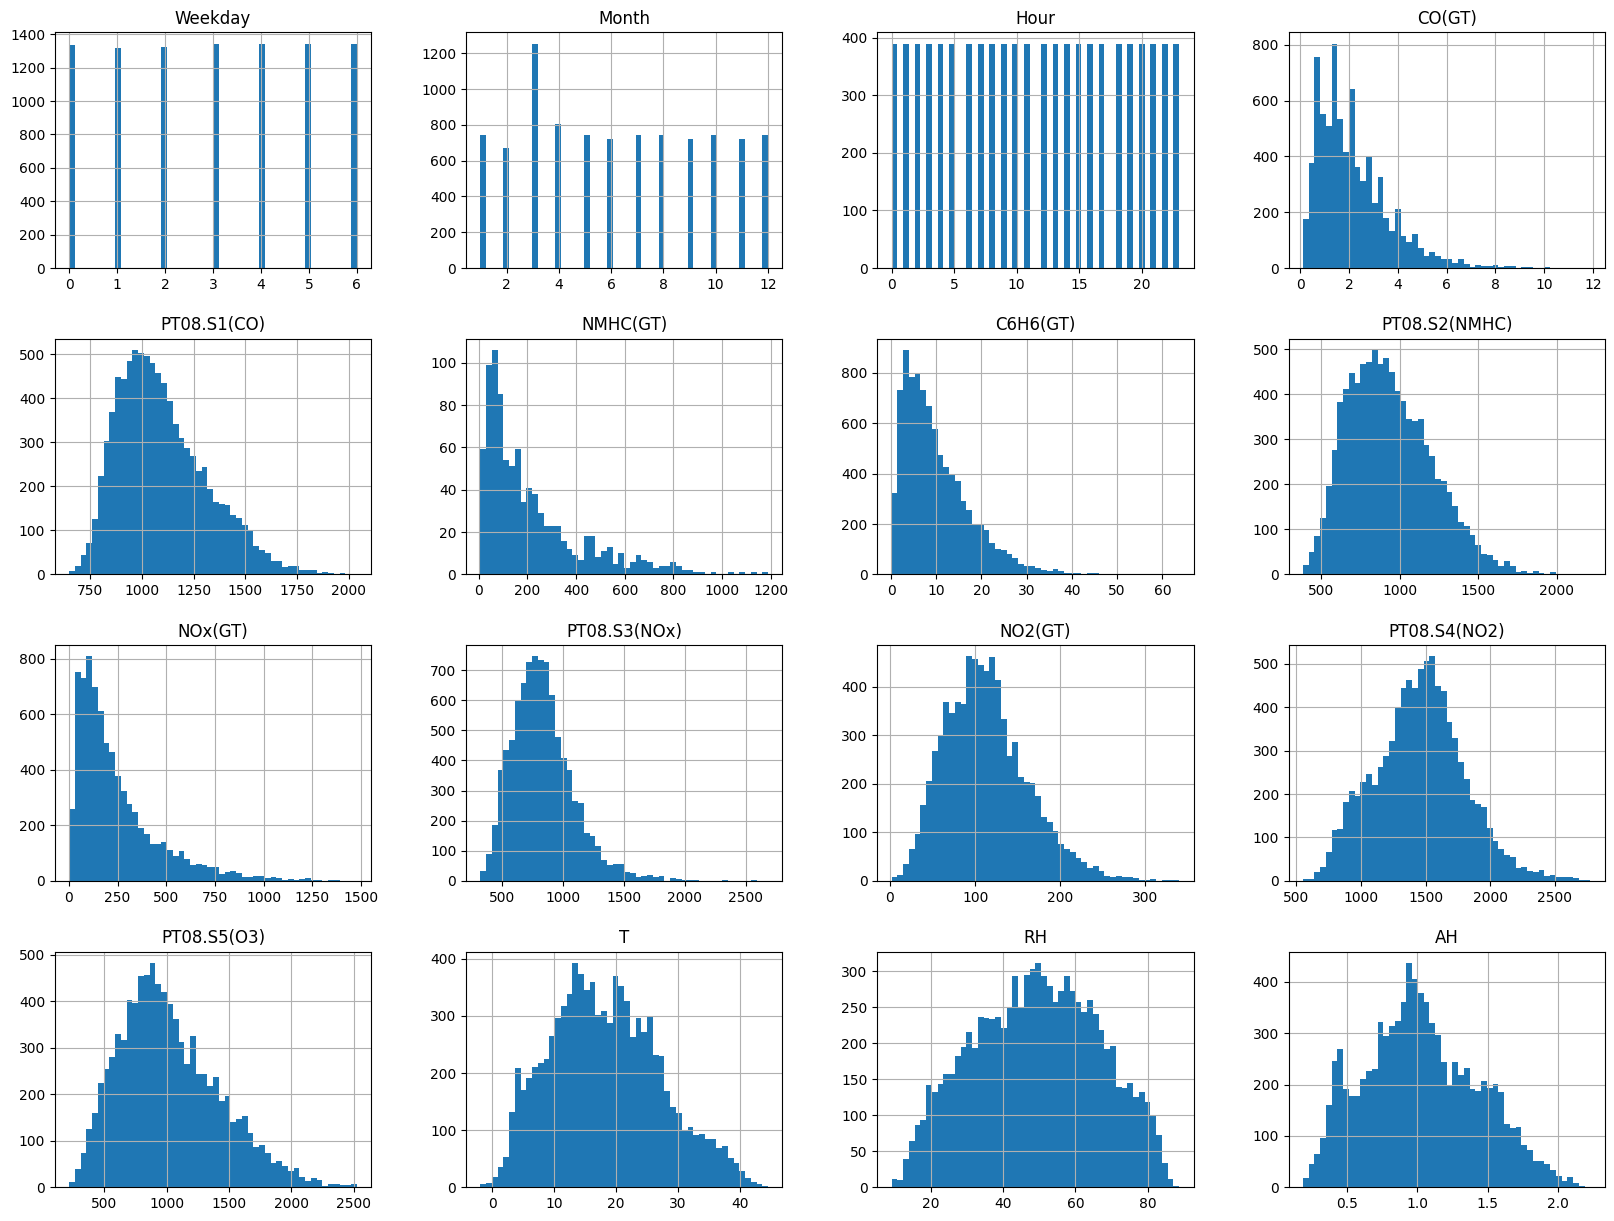

In [271]:
print("\nData Distribution:")
df.drop(columns=['Datetime']).hist(bins=50, figsize=(20, 15))
plt.show()

No outliers

### Correlation Analysis


Correlation Matrix:


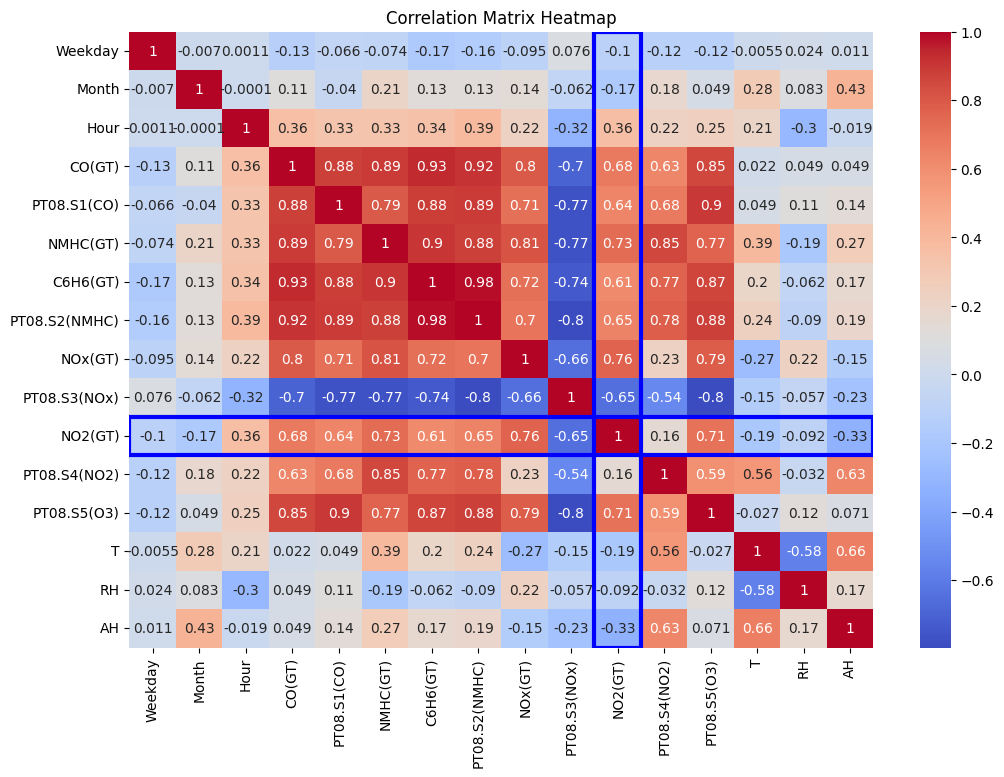

In [272]:
print("\nCorrelation Matrix:")
corr_matrix = df.drop(columns=['Datetime']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Highlight the NO2(GT) column
for i in range(len(corr_matrix.columns)):
    if corr_matrix.columns[i] == 'NO2(GT)':
        plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(corr_matrix.columns), fill=False, edgecolor='blue', lw=3))
        plt.gca().add_patch(plt.Rectangle((0, i), len(corr_matrix.columns), 1, fill=False, edgecolor='blue', lw=3))

plt.title('Correlation Matrix Heatmap')
plt.show()

## Create NaN-handler models

In [273]:
df.drop(columns=['Datetime'], inplace=True)
df.dropna(subset=['NO2(GT)'], inplace=True)

In [274]:
X = df.drop(columns=['NO2(GT)'])
y = df['NO2(GT)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Generic XGB

In [275]:
generic_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
generic_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [276]:
y_pred_generic_xgb = generic_xgb.predict(X_test)

In [277]:
generic_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_generic_xgb))
generic_xgb_r2 = r2_score(y_test, y_pred_generic_xgb)

print(f'RMSE: {generic_xgb_rmse}')
print(f'R²: {generic_xgb_r2}')

RMSE: 11.934286509726611
R²: 0.9347246964362433


### Tune XGBoost

Define the objective function for Hyperopt

In [ ]:
def xgb_objective(params):
    # Convert some Hyperopt parameters to the correct types
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    # XGBoost Regressor with given parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        use_label_encoder=False,
        eval_metric='rmse',
        **params  # Pass the hyperparameter dictionary
    )

    # Cross-validation (important for robust evaluation)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)  # Use negative MSE because hyperopt minimizes

    rmse = np.sqrt(-scores.mean()) # Calculate RMSE from negative MSE

    return {'loss': rmse, 'status': STATUS_OK}  # Hyperopt minimizes loss

In [279]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),  # Integer, uniform distribution
    'max_depth': hp.quniform('max_depth', 3, 10, 1),        # Integer, uniform distribution
    'learning_rate': hp.loguniform('learning_rate', -3, 0),    # Logarithmic, uniform distribution
    'gamma': hp.uniform('gamma', 0, 0.5),                    # Uniform distribution
    'subsample': hp.uniform('subsample', 0.6, 1.0),            # Uniform distribution
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0), # Uniform distribution
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),        # Logarithmic, uniform distribution (L1)
    'reg_lambda': hp.loguniform('reg_lambda', -5, 0),       # Logarithmic, uniform distribution (L2)
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1) # Integer, uniform distribution
}

In [ ]:
xgb_tuned_hyperparameters = fmin(
    fn=xgb_objective,
    space=space,
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=100      # Number of iterations (adjust as needed)
)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [05:51<00:00,  3.52s/trial, best loss: 11.282649728625781]


In [281]:
print("Tuned hyperparameters:", xgb_tuned_hyperparameters)

# Train the final model with the best hyperparameters
xgb_tuned_params = {k: int(v) if k in ('n_estimators', 'max_depth', 'min_child_weight') else v for k, v in xgb_tuned_hyperparameters.items()} # Convert to correct types

xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror', 
    use_label_encoder=False,
    eval_metric='rmse',
    **xgb_tuned_params  # Use the best hyperparameters
)

xgb_tuned.fit(X_train, y_train)
y_pred_tuned_xgb = xgb_tuned.predict(X_test)

Tuned hyperparameters: {'colsample_bytree': 0.9629278770149384, 'gamma': 0.0037865470558749448, 'learning_rate': 0.06581923343130648, 'max_depth': 8.0, 'min_child_weight': 7.0, 'n_estimators': 188.0, 'reg_alpha': 0.8290987049729157, 'reg_lambda': 0.13012230066672123, 'subsample': 0.8299024766860454}


c:\Users\uif93590\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [282]:
tuned_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned_xgb))
tuned_xgb_r2 = r2_score(y_test, y_pred_tuned_xgb)

print(f'RMSE: {tuned_xgb_rmse}')
print(f'R²: {tuned_xgb_r2}')

RMSE: 11.346566884273427
R²: 0.9409955270460638


Save the model with joblib.

In [285]:
joblib.dump(xgb_tuned, os.path.join(base_dir, 'data', 'xgb_tuned.joblib'))

['c:\\Users\\uif93590\\Desktop\\SoftwareProjects\\air-quality\\data\\xgb_tuned.joblib']

### Generic LightGBM

In [ ]:
generic_lgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
generic_lgbm_model.fit(X_train, y_train)
y_pred_generic_lgbm = generic_lgbm_model.predict(X_test)
rmse_generic_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_generic_lgbm))
r2_generic_lgbm = r2_score(y_test, y_pred_generic_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 6172, number of used features: 15
[LightGBM] [Info] Start training from score 113.375421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
print(f'LightGBM RMSE: {rmse_generic_lgbm}')
print(f'LightGBM R²: {r2_generic_lgbm}')

LightGBM RMSE: 12.346274548148308
LightGBM R²: 0.9301401190767131


### Tuned LightGBM

In [ ]:
def lgbm_objective(trial):
    # 1. Define the hyperparameter search space within the Optuna trial
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),  # Log scale for learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # Log scale for regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # 2. Cross-validation loop
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        lgbm = lgb.LGBMRegressor(**param_grid, random_state=42, n_jobs=-1)
        lgbm.fit(X_train_fold, y_train_fold)

        y_pred = lgbm.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        cv_scores.append(rmse)

    # 3. Return the mean cross-validation score (Optuna minimizes)
    return np.mean(cv_scores)  # We want to minimize RMSE

### CatBoost

In [259]:
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_cat = r2_score(y_test, y_pred_cat)

In [260]:
print(f'CatBoost RMSE: {rmse_cat}')
print(f'CatBoost R²: {r2_cat}')

CatBoost RMSE: 13.559195222005723
CatBoost R²: 0.9157395434855243


### Visualization

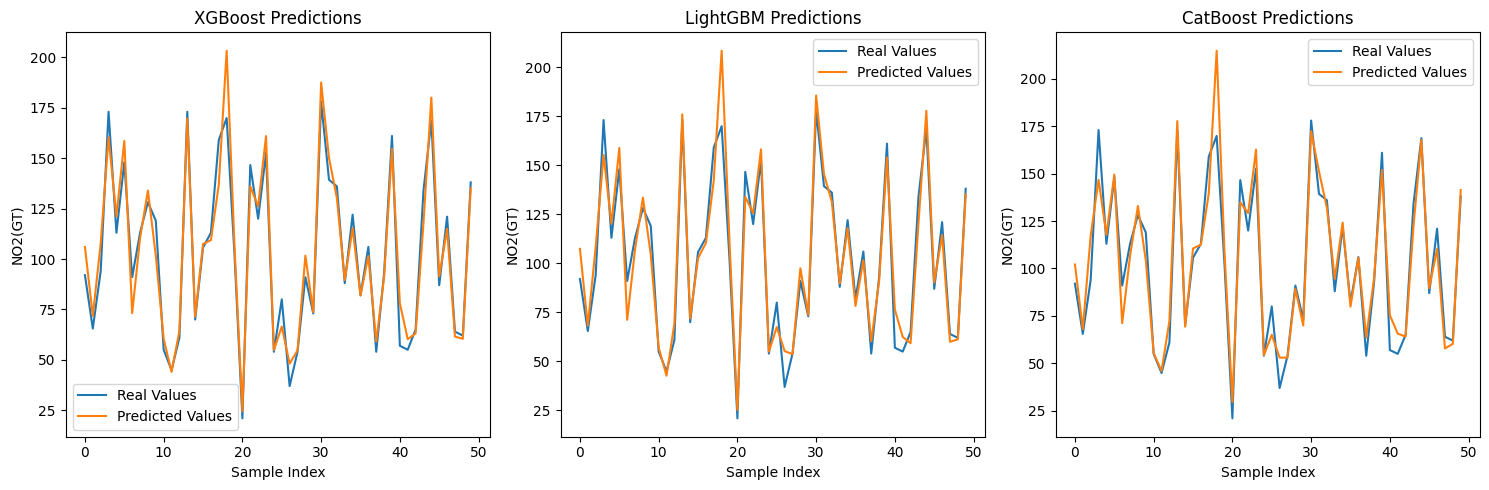

In [ ]:
plt.figure(figsize=(15, 5))

# XGBoost
plt.subplot(1, 3, 1)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_generic_xgb[:50], label='Predicted Values')
plt.title('XGBoost Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

# LightGBM
plt.subplot(1, 3, 2)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_generic_lgb[:50], label='Predicted Values')
plt.title('LightGBM Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

# CatBoost
plt.subplot(1, 3, 3)
plt.plot(y_test.values[:50], label='Real Values')
plt.plot(y_pred_cat[:50], label='Predicted Values')
plt.title('CatBoost Predictions')
plt.xlabel('Sample Index')
plt.ylabel('NO2(GT)')
plt.legend()

plt.tight_layout()
plt.show()

## Impute missing values to make other models applicable